## INTRODUZIONE

First we install the required packages and import the libraries

In [ ]:
!pip install nltk
!pip install transformers
!pip install torch
!pip install contractions
!pip install flair
!pip install transformers[torch]

In [ ]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil
import pandas as pd
import numpy as np
import spacy
import spacy.cli
import re
import nltk
from transformers import AutoTokenizer
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.downloader import load
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
import contractions
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string
from transformers import BertTokenizerFast, TFBertModel, RobertaTokenizerFast, TFRobertaModel
from tensorflow import keras
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from nltk.stem import WordNetLemmatizer
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support

We start by loading the dataset present at the link: https://www.kaggle.com/datasets/kouroshalizadeh/history-of-philosophy

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'history-of-philosophy:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1148703%2F2075750%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240605%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240605T160845Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8c37468c78db9e9d2057791d9d552edd7f90b45b25deb936a95c056e7741f76d3a7d378867d36de56a0a5ce996df0aec5f2b1cc7e0e4bf77fcdf56122bd31d9d4c94bbad042ca5ea7c43b8b1a6f4429078b9ce32f6e536f65dac705d15e786a3fb701e950a2ee219557acec0612d126b3c9c6fb30cda07b5f9b326d673e9ac623984b2ace048e6a19db3616492f7ee079307020819801926f885c65e4522640eecb4890f61ec923dbdd3d9e65aa7d330e335fc2948ac11463997e0133e56d1401ef255d9972ef38e5db5b614689420668a76c4863f1824d53c046f3c3aebbd3bd6ef2fc255a11402e8fceeb8818b0f656e1542b22352054d4282bd3d19f1c4c4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 57826536 bytes downloaded
Downloaded and uncompressed: history-of-philosophy
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/history-of-philosophy/philosophy_data.csv


In [ ]:
DATASET = pd.read_csv("/kaggle/input/history-of-philosophy/philosophy_data.csv")
print(df.info())

# spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('stopwords')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360808 entries, 0 to 360807
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   title                      360808 non-null  object
 1   author                     360808 non-null  object
 2   school                     360808 non-null  object
 3   sentence_spacy             360808 non-null  object
 4   sentence_str               360808 non-null  object
 5   original_publication_date  360808 non-null  int64 
 6   corpus_edition_date        360808 non-null  int64 
 7   sentence_length            360808 non-null  int64 
 8   sentence_lowered           360808 non-null  object
 9   tokenized_txt              360808 non-null  object
 10  lemmatized_str             360808 non-null  object
dtypes: int64(3), object(8)
memory usage: 30.3+ MB
None


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## WORD-USAGE

In [ ]:
dati= pd.DataFrame(DATASET)
dati_rest= dati.sample(10000)
dati = dati.iloc[:,1:5]
print(dati.shape)

gruppi_scuola = dati.groupby('school')
frasi = gruppi_scuola['school'].value_counts()
frasi

(360808, 4)


school
analytic           55425
aristotle          48779
capitalism         18194
communism          17958
continental        33779
empiricism         19931
feminism           18635
german_idealism    42136
nietzsche          13548
phenomenology      28573
plato              38366
rationalism        22949
stoicism            2535
Name: count, dtype: int64

The dataset is preprocessed: we lowercase all words, we remove all characters that are not letters, underscores or spaces from the data; all the phrases are tokenized through NLTK and, in them, are removed all the stopwords.

In [ ]:
# general cleaning
dati = dati.applymap(lambda x: x.lower() if isinstance(x, str) else x)
dati = dati.replace(to_replace=r'[^\w\s]', value='', regex=True)
dati = dati.replace(to_replace=r'\d', value='', regex=True)

# tokenizzation
dati['tokenized_sentence'] = dati['sentence_str'].apply(word_tokenize)

# remove the stop_words
stop_words = set(stopwords.words('english'))
dati['tokenized_sentence'] = dati['tokenized_sentence'].apply(lambda x: [word for word in x if word not in stop_words])

In [ ]:
dati

,author,school,sentence_spacy,sentence_str,tokenized_sentence
0,plato,plato,whats new socrates to make you leave your usu...,whats new socrates to make you leave your usu...,"[whats, new, socrates, make, leave, usual, hau..."
1,plato,plato,surely you are not prosecuting anyone before t...,surely you are not prosecuting anyone before t...,"[surely, prosecuting, anyone, king, archon]"
2,plato,plato,the athenians do not call this a prosecution b...,the athenians do not call this a prosecution b...,"[athenians, call, prosecution, indictment, eut..."
3,plato,plato,what is this you say,what is this you say,[say]
4,plato,plato,someone must have indicted you for you are not...,someone must have indicted you for you are not...,"[someone, must, indicted, going, tell, indicte..."
...,...,...,...,...,...
360803,davis,feminism,but the socialization of housework including m...,but the socialization of housework including m...,"[socialization, housework, including, meal, pr..."
360804,davis,feminism,the only significant steps toward endingdomest...,the only significant steps toward endingdomest...,"[significant, steps, toward, endingdomestic, s..."
360805,davis,feminism,working women therefore have a special and vit...,working women therefore have a special and vit...,"[working, women, therefore, special, vital, in..."
360806,davis,feminism,moreover under capitalism campaigns for jobs o...,moreover under capitalism campaigns for jobs o...,"[moreover, capitalism, campaigns, jobs, equal,..."


### First method: importing **glove** model to find synonimus

The GloVe (Global Vectors for Word Representation) model is a technique for word embedding developed by Stanford. GloVe is based on the global statistical analysis of word co-occurrences within a corpus. Unlike Word2Vec, which trains a predictive model based on words' proximity within a context window, GloVe generates word vectors that capture semantic relationships between words using a global co-occurrence matrix.

In this example, we are loading a pre-trained GloVe model using the Word2Vec format. This allows us to use the GloVe model with the functionalities and interfaces of Word2Vec provided by the gensim library.

The 'glove-wiki-gigaword-50' model has been trained on a large text corpus (Wikipedia and Gigaword) and produces 50-dimensional word vectors.

GloVe is a word embedding approach that leverages global word co-occurrence statistics. The central idea is that words appearing in similar contexts will have similar vectors. GloVe constructs a co-occurrence matrix, where each element of the matrix represents how often one word appears in the context of another word. It then uses this matrix to learn word vectors that minimize a loss function based on the probability of co-occurrence:

$
J = \sum_{i,j=1}^{V} f(X_{ij}) \left( w_i^T \tilde{w}_j + b_i + \tilde{b}_j - \log X_{ij} \right)^2
$

V: Size of the vocabulary.

$X_{ij}$: Number of times word $j$ appears in the context of word $i$.

$w_i$: Word vector for the target word $i$.

$\tilde{w}_j$: Word vector for the context word $j$.

$b_i$: Bias for the target word $i$.

$\tilde{b}_j$: Bias for the context word $j$.

$f(X_{ij})$: Weighting function that reduces the impact of very frequent co-occurrences.


In [ ]:
glove_model = KeyedVectors.load_word2vec_format(load('glove-wiki-gigaword-50', return_path=True))

[==================================================] 100.0% 66.0/66.0MB downloaded


We implement a function that returns the first 5 synonyms of given input word, according to the model GloVe.

In [ ]:
# find the synonymous of the words
def find_synonyms(word, model, topn=5):
    if word in model:
        return model.most_similar(word, topn=topn)
    else:
        return []

We create a dictionary where the keys are the philosophical schools and the values are lists containing the tokenized phrases belonging to the school

In [ ]:
frasi_raggruppate = {}

for index, row in dati.iterrows():
    scuola = row['school']
    frase = row['tokenized_sentence']
    if scuola not in frasi_raggruppate:
        frasi_raggruppate[scuola] = []
    frasi_raggruppate[scuola].append(frase)

To assess the linguistic variety is possible to analyze the unique words percentage for each school: we create a graph that shows how this percentage changes among the philosophical schools: it is possible to notice that the more contemporary schools of thought have a higher value, perhaps due to the greater variety and complexity of topics covered; the exception being Stoicism, which has the bias of having a significantly lower total word count.

School: plato
Total number of words: 361761
Total number of unique words: 18718
Unique word percentage: 5.174134304140026 %

School: aristotle
Total number of words: 585799
Total number of unique words: 21227
Unique word percentage: 3.623597855237035 %

School: empiricism
Total number of words: 289316
Total number of unique words: 12914
Unique word percentage: 4.463631461792642 %

School: rationalism
Total number of words: 303728
Total number of unique words: 19056
Unique word percentage: 6.274034662592847 %

School: analytic
Total number of words: 547636
Total number of unique words: 25572
Unique word percentage: 4.669525012964816 %

School: continental
Total number of words: 468152
Total number of unique words: 29082
Unique word percentage: 6.212084963857892 %

School: phenomenology
Total number of words: 329996
Total number of unique words: 21447
Unique word percentage: 6.4991696869052955 %

School: german_idealism
Total number of words: 583204
Total number of unique words: 29082
Un

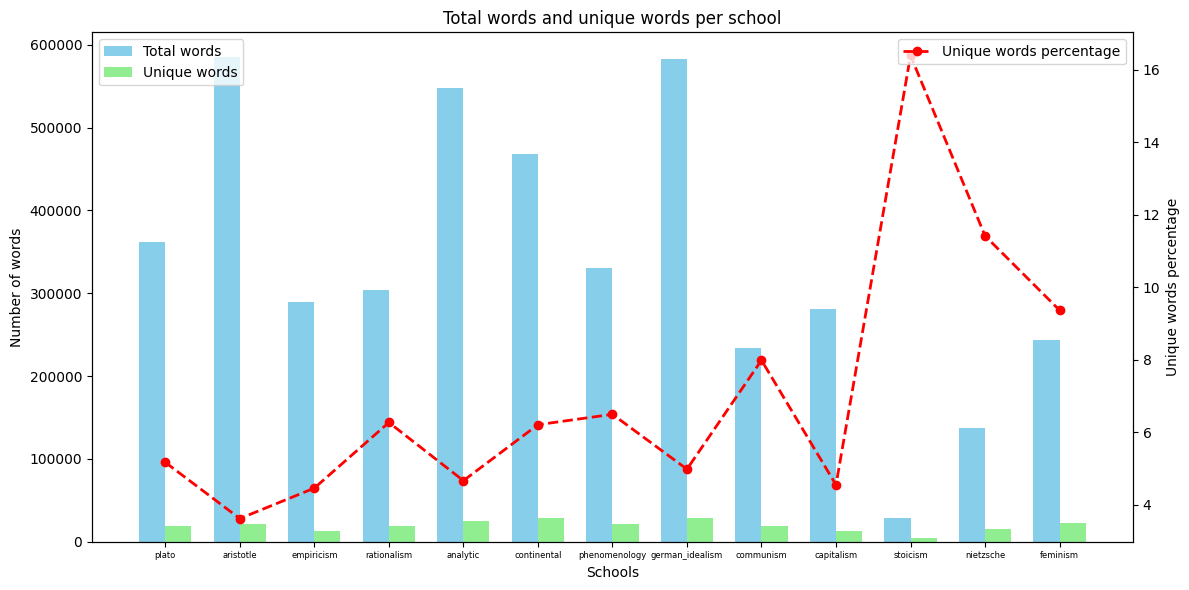

In [ ]:
# Iterate over each category in frasi_raggruppate
for school, sentences in frasi_raggruppate.items():
    schools = []
total_words_list = []
total_unique_words_list = []
unique_word_percentages = []

# Iterate over each category in frasi_raggruppate
for school, sentences in frasi_raggruppate.items():

    total_words = sum(len(sublist) for sublist in sentences)

    # Find and count the unique words
    unique_words = set()
    for sublist in sentences:
        for word in sublist:
            unique_words.add(word)
    total_unique_words = len(unique_words)

    # Compute the unique words percentage
    unique_word_percentage = (total_unique_words / total_words) * 100

    schools.append(school)
    total_words_list.append(total_words)
    total_unique_words_list.append(total_unique_words)
    unique_word_percentages.append(unique_word_percentage)

    print(f"School: {school}")
    print(f"Total number of words: {total_words}")
    print(f"Total number of unique words: {total_unique_words}")
    print(f"Unique word percentage: {unique_word_percentage} %\n")

fig, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(len(schools))
width = 0.35
bars1 = ax1.bar(x - width/2, total_words_list, width, label='Total words', color='skyblue')
bars2 = ax1.bar(x + width/2, total_unique_words_list, width, label='Unique words', color='lightgreen')

ax1.set_xlabel('Schools')
ax1.set_ylabel('Number of words')
ax1.set_title('Total words and unique words per school')
ax1.set_xticks(x)
ax1.set_xticklabels(schools, fontsize=6)
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(x, unique_word_percentages, color='red', marker='o', linestyle='dashed', linewidth=2, markersize=6, label='Unique words percentage')
ax2.set_ylabel('Unique words percentage')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('grafico_parole.png', format='png')  # Salva il grafico come file PNG

plt.show()

We create a function that return the first n common words in each school, this can help us to choose the word to give in input to the model:

In [ ]:
def most_common_words(frasi_raggruppate):
    all_tokens = [token for tokens in frasi_raggruppate for token in tokens]

    word_freq = Counter(all_tokens)

    most_common_words = word_freq.most_common()

    vocab_df = pd.DataFrame(most_common_words, columns=['Most_common_words', 'Frequency'])

    return vocab_df

print(most_common_words(frasi_raggruppate['capitalism']).head(30))

   Most_common_words  Frequency
0              would       2959
1              price       2328
2               upon       2210
3              money       1893
4             labour       1783
5              value       1767
6              great       1758
7            capital       1647
8                may       1613
9               part       1597
10           country       1593
11               one       1566
12          quantity       1514
13           produce       1506
14           greater       1317
15          interest       1300
16              much       1288
17              must       1257
18             trade       1207
19         therefore       1202
20              rate       1115
21              land       1105
22         different       1069
23             every       1030
24             wages        964
25              rent        957
26             could        950
27              corn        934
28               tax        930
29             whole        918


In [ ]:
# Example

dataset_voc= most_common_words(frasi_raggruppate["capitalism"])['Most_common_words']
dataset_vocab=set()
for word in dataset_voc:
    if word in glove_model:
        dataset_vocab.add(word)

def find_dataset_synonyms(word, model, dataset_vocab, topn=20):
    similar_words = find_synonyms(word, model, topn=topn)
    dataset_synonyms = [w for w, _ in similar_words if w in dataset_vocab]
    return dataset_synonyms

dataset_synonyms = find_dataset_synonyms("price", glove_model, dataset_vocab)
dataset_synonyms

['prices',
 'sales',
 'market',
 'drop',
 'stock',
 'higher',
 'rise',
 'earnings',
 'value',
 'demand',
 'costs',
 'rates',
 'buying',
 'rose',
 'rate',
 'share',
 'interest',
 'increase',
 'trading']

### SECOND METHOD: WORD2VEC TO FIND CONTEXT WORDS

The Word2Vec model, specifically the skip-gram model, is employed to represent words in a continuous vector space, where each word is mapped to a dense vector of a fixed size (vector_size). This model is trained on a set of tokenized sentences to learn vector representations of words that capture semantic relationships between them.

The skip-gram model predicts a target word given context words. During training, the model adjusts word vectors to minimize prediction error, effectively capturing the context in which words appear.

Once trained, the model can be utilized to find context words of a given input word by examining the similarity between word vectors in the vector space.

For our specific case, the parameters used are as follows:

- `sentences`: Represents the set of tokenized sentences utilized to train the Word2Vec model.

- `vector_size`: Set to 50, this parameter defines the dimensionality of the word vectors generated by the model. Each word in the vocabulary is represented by a vector of 50 dimensions.

- `window`: Set to 5, this parameter specifies the size of the context window considered by the model during training. The model considers the 5 preceding and 5 following words of a given word as context during training.

- `min_count`: Set to 1, this parameter specifies the minimum frequency of words in the training corpus to be included in the model's vocabulary. In this case, all words present in the corpus are included in the vocabulary, even those with a frequency of only once.

- `workers`: Set to 4, this parameter specifies the number of worker threads utilized during training of the Word2Vec model. With 4 worker threads, model training can be executed in parallel on hardware with at least 4 CPU cores, if available, to accelerate the training process.

In our analysis, we employed three distinct methods to identify context words for a given input word within the Word2Vec model. Firstly, we utilized the most_similar function, a built-in method in Word2Vec, which returns the most similar words to a given word based on cosine similarity scores. This approach allows us to directly leverage the trained Word2Vec model to retrieve context words by querying for the most semantically similar words in the vector space.

Secondly, we employed the dot product operation (np.dot) to compute the similarity between the vector representation of the input word and all other words in the vocabulary. By calculating the dot product, we obtain a measure of similarity that reflects the alignment of vectors in the vector space. This method enables us to identify context words by quantifying the degree of overlap between the vector representations of words.

Lastly, we utilized the cosine_similarity function to compute the cosine similarity between the vector representation of the input word and all other words in the vocabulary. Cosine similarity measures the cosine of the angle between two vectors and is particularly well-suited for comparing vectors in high-dimensional spaces. By employing cosine similarity, we are able to assess the similarity between vectors while normalizing for their magnitudes, providing a robust measure of semantic similarity between words.

While find_similar_words uses the dot product for similarity computation, which may not always yield normalized results, find_similar_words_cosine utilizes cosine similarity, ensuring normalized similarities between -1 and 1. This distinction highlights the trade-off between efficiency and normalization in similarity calculations.


In [ ]:
# Prepare data for Word2Vec

# example on philosophical school of Plato
dati1= dati[dati['school']== 'plato']
# we transform our data in lists
sentences = dati1['tokenized_sentence'].tolist()

# We train the Word2Vec model with our data
model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)

# The trained model is saved
model.save("word2vec.model")

# We load it
model = Word2Vec.load("word2vec.model")
# print(model)

# the word man is used as an example, to see how it is contextualized in the Plato philosophy
word="man"

# To find the context words of the given input we use the implemented method "most_similar"
similar_words = model.wv.most_similar(word, topn=10)
print('Similar Words: ', similar_words)

vector = model.wv[word]
# print(vector)

# we define the second method to find context words
lista_di_liste= frasi_raggruppate['plato']

# Flatten the list of lists into a single list using itertools.chain
lista_unica = list(itertools.chain(*lista_di_liste))
# Extract unique words from the flattened list
word_unique=list(set(lista_unica))
# Create a dictionary where each unique word is mapped to its index (starting from 1)
word_index = {word: idx+1 for idx, word in enumerate(word_unique)}
# Generate word embeddings for each unique word using the Word2Vec model
embed = np.array([model.wv[word] for word in word_unique])


def find_similar_words(word, embeddings, word_index, top_n=10):
    if word not in word_index.keys():
        return []
    # Get the index of the given word from the word index
    word_idx = word_index[word]
    # Retrieve the embedding vector of the given word
    word_embedding = embeddings[word_idx]
    # Compute the dot product between the embedding of the given word and all other embeddings
    similarities = np.dot(embeddings, word_embedding)
    # Get the indices of the most similar words
    similar_indices = similarities.argsort()[-top_n-1:-1][::-1]
    similar_words = [list(word_index.keys())[i] for i in similar_indices]
    return similar_words

similar_words = find_similar_words(word, embed, word_index)
print('similar 2: ', similar_words)

Similar Words:  [('become', 0.9680719971656799), ('neither', 0.9630681872367859), ('person', 0.9600859880447388), ('worse', 0.9598298072814941), ('fortune', 0.9568518996238708), ('unjust', 0.9557666182518005), ('virtuous', 0.9555523991584778), ('shameful', 0.9552134871482849), ('ugly', 0.9542807936668396), ('wise', 0.9537807106971741)]
similar 2:  ['else', 'bad', 'parts', 'around', 'different', 'know', 'called', 'part', 'rest', 'body']


**Cosine similarity** method

In [ ]:
dati1= dati[dati['school']== 'plato']
sentences = dati1['tokenized_sentence'].tolist()

model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)

model.save("word2vec.model")

model = Word2Vec.load("word2vec.model")
# print(model)

word="man"
similar_words = model.wv.most_similar(word, topn=10)
print('Similar Words: ', similar_words)

vector = model.wv[word]
#print(vector)

word_unique=list(set(lista_unica))
lista_di_liste= frasi_raggruppate['plato']
lista_unica = list(itertools.chain(*lista_di_liste))
word_index = {word: idx+1 for idx, word in enumerate(word_unique)}
embed = np.array([model.wv[word] for word in word_unique])


def find_similar_words_cosine(word, embeddings, word_index, top_n=10):
    if word not in word_index.keys():
        return []
    word_idx = word_index[word]
    word_embedding = embeddings[word_idx].reshape(1,-1)
    # Compute the cosine similarity between the embedding of the given word and all other embeddings
    similarities = cosine_similarity(word_embedding, embeddings).flatten()
    similar_indices = similarities.argsort()[-top_n-1:-1][::-1]
    similar_words = [list(word_index.keys())[i] for i in similar_indices]
    return similar_words

similar_words = find_similar_words_cosine(word, embed, word_index)
print('similar 2: ', similar_words)

Similar Words:  [('wise', 0.9704236388206482), ('become', 0.9697465896606445), ('unjust', 0.9569907188415527), ('wicked', 0.954826295375824), ('neither', 0.952988862991333), ('makes', 0.9494554996490479), ('person', 0.9494548439979553), ('cares', 0.9462746381759644), ('ugly', 0.9452780485153198), ('virtuous', 0.9444013237953186)]
similar 2:  ['mans', 'provides', 'lack', 'goods', 'proportion', 'eternal', 'result', 'movement', 'pure', 'leading']


### Model 1

In [ ]:
# Create an empty DataFrame to store the results with columns: School, Word, Synonyms.
data_out = pd.DataFrame(columns=['School', 'Word', 'Synonyms'])

def modello_1():
    schools= np.unique(dati['school'])
    for idx, school in enumerate(schools):

        frasi_per_scuola= frasi_raggruppate[school]
        print(f"School : {school}")
        print(most_common_words(frasi_per_scuola).head(30))
        dataset_voc= most_common_words(frasi_raggruppate[school])['Most_common_words']
        dataset_vocab=set()
        for word in dataset_voc:
            if word in glove_model:
                dataset_vocab.add(word)

        # Prompt the user to input a word to find synonyms for, ensuring it exists in the filtered vocabulary.
        word= input(str("Insert the word to find: "))
        while True:
            if not word in dataset_vocab:
                word= input(str("Insert the correct word to find: "))
            else:
                break
        dataset_synonyms = find_dataset_synonyms(word, glove_model, dataset_vocab)
        print(f"Synonyms of -- {word} --: {dataset_synonyms}")

        # Add new row
        data_out.loc[idx] = [school, word, dataset_synonyms]

        # Prompt the user to press Enter to clear the shell for better interaction and visualization.
        input(str("Press ENTER to clear the shell"))

        # Clear the shell to aid interaction and visualization.
        clear_output(wait=True)


### Model 2

In [ ]:
# Create an empty DataFrame to store the results with columns: School, Word, Similar_1(most_similar), similar_2(np.dot), similar_3(cosine_similarity).
data_out1 = pd.DataFrame(columns=['School', 'Word', 'Similar_1', 'similar_2', 'similar_3'])

def modello_2():
    schools= np.unique(dati['school'])
    for idx, school in enumerate(schools):
        # second model
        dati1= dati[dati['school']== school]
        sentences = dati1['tokenized_sentence'].tolist()

        model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)

        model.save("word2vec.model")

        model = Word2Vec.load("word2vec.model")

        frasi_per_scuola= frasi_raggruppate[school]
        print(f"School : {school}")
        print(most_common_words(frasi_per_scuola).head(30))
        dataset_voc= most_common_words(frasi_raggruppate[school])['Most_common_words']
        word= input(str("Insert the word to find: "))

        vector = model.wv[word]
        # print(vector)

        lista_di_liste= frasi_per_scuola
        lista_unica = list(itertools.chain(*lista_di_liste))
        word_unique=list(set(lista_unica))
        word_index = {word: idx+1 for idx, word in enumerate(word_unique)}
        embed = np.array([model.wv[word] for word in word_unique])

        # Find similar words using three different methods.
        # Fist method: most_similar
        similar_words_1 = model.wv.most_similar(word, topn=10)
        print('Similar Words 1: ', similar_words_1)

        # Second method: np.dot
        similar_words_2 = find_similar_words(word, embed, word_index)
        print('Similar Words 2: ', similar_words_2)

        # Third method: Cosine_similarity
        similar_words_3 = find_similar_words_cosine(word, embed, word_index)
        print('Similar Words 3: ', similar_words_3)

        # Add new row
        data_out1.loc[idx] = [school, word, similar_words_1, similar_words_2, similar_words_3]

        input(str("Press ENTER to clear the shell"))
        clear_output(wait=True)



### Results

The chosen input words are: "language" for Analytic, "body" for Aristotle, "capital" for Capitalism, "capital" for Communism, "language" for Continental, "experience" for Empiricsm, "woman" for Feminism, "concept" for German Idealism, "god" for Nietzsche, "consciusness" for Phenomenology, "body" for Plato, "reason" for Rationalism and "things" for Stoicism

In [ ]:
modello_1()

School : stoicism
   Most_common_words  Frequency
0               thou        798
1             things        568
2               unto        436
3                thy        338
4                one        313
5               thee        306
6                man        302
7             nature        268
8             either        251
9               doth        247
10              good        195
11           thyself        193
12              must        188
13        whatsoever        171
14              also        165
15             world        155
16              upon        153
17             shall        150
18               may        147
19              mind        142
20              life        136
21              hath        136
22              time        134
23              many        125
24          anything        124
25               men        120
26             thing        119
27         therefore        118
28               yet        117
29           another  

In [ ]:
modello_2()

School : stoicism
   Most_common_words  Frequency
0               thou        798
1             things        568
2               unto        436
3                thy        338
4                one        313
5               thee        306
6                man        302
7             nature        268
8             either        251
9               doth        247
10              good        195
11           thyself        193
12              must        188
13        whatsoever        171
14              also        165
15             world        155
16              upon        153
17             shall        150
18               may        147
19              mind        142
20              life        136
21              hath        136
22              time        134
23              many        125
24          anything        124
25               men        120
26             thing        119
27         therefore        118
28               yet        117
29           another  

In [ ]:
data_out.to_csv('output_modello_1__.csv', index=False)
data_out

,School,Word,Synonyms
0,analytic,language,"[languages, word, spoken, vocabulary, translat..."
1,aristotle,body,"[bodies, blood, attached, hand, head, found, h..."
2,capitalism,capital,"[central, city, northern, east, eastern, bank,..."
3,communism,capital,"[central, city, northwest, region, northern, e..."
4,continental,language,"[languages, word, spoken, vocabulary, translat..."
5,empiricism,experience,"[experiences, life, learning, physical, good, ..."
6,feminism,woman,"[girl, man, mother, boy, child, wife, old, vic..."
7,german_idealism,concept,"[concepts, model, idea, evolution, theory, des..."
8,nietzsche,god,"[divine, heaven, christ, faith, holy, sacred, ..."
9,phenomenology,consciousness,"[cognition, unconscious, emotions, perception,..."


- Analytic - language: it finds 19 synonyms of the word and they refer to the natural language and the formal language.
- Aristotle - body: it finds 18 synonyms of the word and they refer to the anatomic and physical definition of body.
- Capitalism - capital: it finds 10 synonyms of the word and they refer to the geographical definition of the term.
- Communism - capital: it finds 15 synonyms of the word and they refer to the geographical definition of the term.
- Continental - language: it finds 19 synonyms of the word and they refer to the natural language and the formal language.
- Empiricism - experience: it finds 17 synonyms of the word and they refer to an experienced event and to the sensibility/sensation.
- Feminism - woman: it finds 17 synonyms of the word and they refer to familiy roles and relationships.
- German Idealism - concept: it finds 20 synonyms of the word and they refer to a central idea or notion guiding the understanding, representation, and explanation of phenomena in various contexts.
- Nietzsche - god: it finds 19 synonyms of the word and they refer to the religious and spiritual context.
- Phenomenology - consciousness: it finds 18 synonyms of the word and they refer to the mental processes, emotions and perceptions.
- Plato - body: it finds 18 synonyms of the word and they refer to the anatomic and physical definition of body.
- Rationalism - reason: it finds 13 synonyms of the word and they refer to the thought process, to certainty or uncertainty, and to the possibility of explaining or understanding something.
- Stoicism - thing: it finds 14 synonyms of the word and they refer to various general situations, ideas or concepts.

In [ ]:
data_out1.to_csv('output_modello_2__.csv', index=False)
data_out1

,School,Word,Similar_1,similar_2,similar_3
0,analytic,language,"[(game, 0.8918954730033875), (overlapped, 0.88...","[language, names, use, word, meaning, proper, ...","[disapproved, ntemion, obstructed, udgmenh, ra..."
1,aristotle,body,"[(upper, 0.911085844039917), (part, 0.90717971...","[equal, belong, number, species, different, tw...","[crossed, sexes, respects, homonymously, compa..."
2,capitalism,capital,"[(employed, 0.9750670194625854), (employment, ...","[stock, marginal, increase, capital, land, pro...","[powers, maintaining, division, labourers, nat..."
3,communism,capital,"[(variable, 0.9930150508880615), (commodity, 0...","[de, surplus, labour, like, capital, power, me...","[rent, reality, quantities, far, gives, former..."
4,continental,language,"[(form, 0.978421151638031), (truth, 0.97770857...","[et, flows, sciences, production, des, non, or...","[gather, exhaust, differentiate, differing, di..."
5,empiricism,experience,"[(faculties, 0.996153712272644), (observation,...","[substances, species, essence, gold, people, c...","[last, laid, beasts, obscurity, questions, met..."
6,feminism,woman,"[(feels, 0.9994944930076599), (object, 0.99948...","[black, new, white, well, like, often, time, l...","[family, death, nothing, mothers, house, educa..."
7,german_idealism,concept,"[(reality, 0.9043118953704834), (abstract, 0.8...","[negation, positedness, determinateness, quant...","[lord, gains, arising, coming, spring, preserv..."
8,nietzsche,god,"[(christian, 0.9996881484985352), (old, 0.9996...","[thou, even, self, old, also, upon, everything...","[heart, eternal, without, courage, find, thoug..."
9,phenomenology,consciousness,"[(experience, 0.9820817708969116), (nature, 0....","[present, taking, hand, things, toward, de, te...","[interpreters, educational, psychanalyses, sur..."


By observing the results obtained from the three methods, the following conclusions can be drawn. The `most_similar` methods of `Word2Vec` and cosine similarity provide more precise and relevant results compared to the dot product. This is because both methods are based on cosine similarity, which is a normalized and directional measure. It is not influenced by the length of the vectors, allowing for a better capture of semantic relationships between words. In contrast, the dot product (`np.dot`) tends to provide more general results. Since this measure is not normalized, its values can be influenced by the length of the vectors, leading to variations that do not necessarily reflect the semantic similarity between words. Consequently, the dot product can return values that vary based on the magnitude of the vectors, limiting its precision in the context of semantic analysis. Cosine similarity, being normalized, is a more reliable measure for determining the relative direction between two vectors. This makes it more suitable for capturing semantic similarity between words, returning values ranging from -1 to 1, with 1 indicating an identical direction and -1 indicating an opposite direction. In conclusion, the use of cosine similarity, either directly or through the `most_similar` method of `Word2Vec`, proves to be superior to the dot product (`np.dot`) in terms of the precision and relevance of the results obtained. This highlights the importance of adopting normalized measures when analyzing semantic relationships between words to achieve more accurate and meaningful results.

**ANALYTIC VS CONTINENTAL**

The concept of language is approached differently in analytic and continental philosophy. Analytic philosophy views language as a tool to analyze the logical structure of thought, focusing on clarity and precision. In this context, language is treated as a series of propositions reflecting states of affairs in the world, and everyday language use is explored to resolve conceptual confusions. In contrast, continental philosophy sees language as intrinsically linked to being and human experience. Here, language is considered fundamental for understanding and interpretation, challenging traditional notions of meaning. In summary, while analytic philosophy treats language as a logical and representational tool, continental philosophy considers it essential for human experience and interaction with the world.

This is highlited by the context words of Analytic "**scorekeeping** , "**intrinsic**", "**logic**", "**math**", "**data**", "**proper**"  and the ones of Continental "**roots** , "**life**", "**conscious**", "**representation**", "**expressions**", "**signifieds**".

**ARISTOTLE VS PLATO**

Plato views the body as a prison for the soul, limiting its access to truth and knowledge. This dualistic view sharply separates the sensible world, dominated by sensory perception, from the world of immutable forms to which the soul belongs. For Plato, the soul is a higher entity than the body, temporarily confined within it during earthly life. On the other hand, Aristotle conceives the body as an essential part of being human, inseparably linked to the soul. The soul is seen as the form or essence that animates the body, making it what it is. This integrated view regards the body as a means through which the soul expresses itself and realizes in the physical world, eliminating the sharp separation between soul and body proposed by Plato.

This is highlited by the context words of Aristotle "**combined**", "**indistinct**", "**part**", "**equal**" and the ones of Plato "**soul**", "**bad**", "**human**", "**evils**",


**CAPITALISM VS COMMUNISM**

In comparing communism and capitalism, the key focus is on the word "capital." In capitalism, capital is at the core of the economic and social system. It encompasses financial resources, means of production, and private property used to generate profit. Capitalism promotes the accumulation of capital through private initiative and free competition, fostering innovation and economic growth. On the other hand, in communism, the concept of capital takes on a different meaning. In communism, the aim is to eliminate private ownership of the means of production and transfer control of goods and resources to the community or the state. The goal is to create an economy based on resource sharing and economic equality, reducing class inequalities. In summary, while capitalism emphasizes the importance of capital accumulation and private ownership to promote economic development, communism seeks to overcome inequalities through the socialization of the means of production and fair distribution of resources.

This is highlited by the context words of Capitalism "**replace**", "**employ**", "**maintainig**", "**productive**" and the ones of Communism "**possessor**", "**relative**", "**revolutionary**", "**millowners**", "**impoverishment**".

**EMPIRICISM**

Empiricists view experience as the primary source of human knowledge. According to their perspective, all ideas and knowledge stem directly or indirectly from sensory experience. Empirical inquiry, based on observation and direct experience, is seen as the most reliable method for acquiring knowledge of the external world and natural phenomena.

This is highlited by the context words of Empiricism "**observations**", "**essence**", "**discovery**".

**FEMMINISM**

Feminist philosophy analyzes and critiques traditional conceptions of women in Western philosophy. It focuses on examining patriarchy and gender discrimination, emphasizing the importance of a female perspective in philosophy and society. This philosophical movement advocates for gender equality, women's autonomy, and the recognition of their rights and unique experiences.

This is highlited by the context words of Feminism "**right**", "**education**", "**flesh**", "**person**", "**love**".

**GERMAN IDEALISM**

In German idealism, Kant regards concepts as mental structures that organize our understanding of reality. Hegel, on the other hand, expands this view, seeing concepts not only as tools of the mind but as constitutive elements of reality itself, in a dialectical process toward an absolute idea. Hegel's concept of dialectics highlights the process in which concepts develop through contradictions toward a higher synthesis, culminating in the Absolute Idea, representing the unity of thought and reality.

This is higlited by the context words of German Idealism "**reality**", "**cludes**", "**multitude**", "**abstract**", "**ideas**", "**category**".

**NIETZSCHE**

For Nietzsche, the concept of "God" plays a crucial role in his philosophy, primarily as an expression of the decline of traditional values and as a symbol of the decline of Western culture. He harshly criticizes the traditional conception of God as a projection of morality and authority, proclaiming the "death of God" as a crucial event marking the end of metaphysics and the emergence of new possibilities for human existence, liberated from traditional morality and open to the creation of new values based on the individual and the affirmation of life.

This is higlited by the context words of Nietzsche "**old**", "**christian**", "**sunshine**", "**shadow**", "**last**", "**belive**".

**PHENOMENOLOGY**

In the realm of phenomenological philosophy, the term "consciousness" holds a central position, representing our direct and immediate awareness of experience. Phenomenologists focus on investigating the structure and nature of consciousness itself, exploring how it relates to the surrounding world and shapes our understanding of reality. Consciousness is regarded as the primary access point to knowledge and understanding of the world, emphasizing the importance of carefully examining subjective experiences to reveal the underlying structures and meanings that inform our perception and understanding of reality.

This is highlited by the context words of Phenomenology "**experience**", "**true**", "**perception**", "**real**", "**pregiven**", "**authentic**".

**RATIONALISM**

In Rationalism, the term "reason" holds a fundamental role, representing the human faculty of thinking, understanding, and justifying knowledge through logic and argumentation. Rationalists consider reason as the primary source of knowledge, surpassing sensory experience and external authority. Rationality and deduction are highly valued, providing a stable foundation for philosophical and scientific inquiry.

This is highlited by the context words in Rationalism "**truth**", "**assure**", "**teachs**", "**equations**".

**STOICISM**

In Stoicism, the concept of "thing" holds a central meaning, reflecting the Stoics' view on the nature of the world and how individuals should relate to it. For the Stoics, "things" encompass everything that exists in the natural and eventful world. This includes not only physical objects but also events, emotions, and thoughts. Stoics emphasize the importance of accepting things as they are and living in harmony with nature, practicing virtue and developing an inner disposition of equanimity in the face of life's challenges. The notion of "thing" in Stoic philosophy thus underscores the centrality of virtue, acceptance, and serenity in pursuing a happy and meaningful life.

This is highlited by the context words in Stoicism "**drop**", "**beneficial**", "**upon**", "**thyself**".

For Stoicism, the limited availability of sentences presents a challenge in finding contextual phrases. With only a few sentences to base our learning on, each word takes on a particular meaning and tight correlation with others. This means that every word, even those common and seemingly devoid of specific meaning in everyday context, is closely connected to other words.

## SENTIMENT ANALYSIS

In [ ]:
df = pd.DataFrame(DATASET)
df.head()

,title,author,school,sentence_spacy,sentence_str,original_publication_date,corpus_edition_date,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...","What's new, Socrates, to make you leave your ...",-350,1997,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea..."
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,Surely you are not prosecuting anyone before t...,-350,1997,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,The Athenians do not call this a prosecution b...,-350,1997,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...
3,Plato - Complete Works,Plato,plato,What is this you say?,What is this you say?,-350,1997,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...","Someone must have indicted you, for you are no...",-350,1997,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ..."


In [ ]:
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns")

The dataset has 360808 rows and 11 columns


The dataset consists of 11 columns and 360808 rows.

Each row represents a fragment of a work.

In order to handle the analysis all from scratch, I decided to eliminate columns for which preprocessing has already occurred and columns that are futile for the final goal. This leaves only 2 columns: **sentence_str** which represents the sentence in its raw state (before uploading the dataset to kaggle some preprocessing was done anyway) and **school** which is the school to which the text belongs.

In [ ]:
df = df[['school', 'sentence_str']]
df.sample(5)

,school,sentence_str
246625,phenomenology,The scales of danger are essentially uncalmed ...
239864,phenomenology,The temporal interpretation of care was then c...
108597,rationalism,"; there is, therefore, a new cause of love, wh..."
204166,continental,at the same time let us understand inspired by...
164522,analytic,"Ta ke conjunction: the chIld notices, by degre..."


### Data Preprocessing and brief Exploratory Analysis

As a first step I define a function to clean the data. Specifically, after a few attempts, the procedure that helps me get the best scores on the validation set involves the following operations:
- transforming the text to lower case
- removal of punctuation
- removal of English stopwords

In addition I create a column with the number of tokens remaining at the end of the cleaning.

In [ ]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

def clean_text(text):
    # Expand contractions
    expanded_text = contractions.fix(text)

    # Convert text to lower case and tokenize
    tokens = word_tokenize(expanded_text.lower())
    # Remove punctuation and stopwords
    clean_tokens = [word for word in tokens if word not in string.punctuation and word not in stopwords.words('english')]

    # Join tokens back to string and calculate length
    cleaned_text = ' '.join(clean_tokens)
    sentence_length = len(clean_tokens)

    return cleaned_text, sentence_length

# Apply the cleaning function
df['text_clean'], df['token_lens'] = zip(*df['sentence_str'].apply(clean_text))
df.sample(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,school,sentence_str,text_clean,token_lens
184276,analytic,", he shows that he believes that what he is lo...",shows believes looking,3
296452,communism,"The result was: From th January to th April, w...",result th january th april twelve hours day av...,12
179068,analytic,"Intuitively, I would say that the method that ...",intuitively would say method used 'sizing age ...,14
136701,analytic,He seems very anxious to insist that reality i...,seems anxious insist reality mutable change ir...,12
235562,phenomenology,With this we adhere to the primordial meaning ...,adhere primordial meaning logos apophansis let...,8


Now I analyze the distribution of the length of the clean sentences

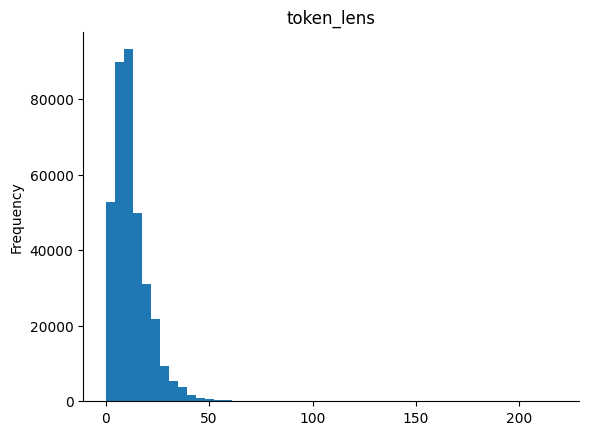

In [ ]:
df['token_lens'].plot(kind='hist', bins=50, title='token_lens')
plt.gca().spines[['top', 'right',]].set_visible(False)

As can be seen from the graph there are many sentences that after cleaning remain without text (length 0) or with very few words that are not meaningful for the study objective. Few sentences on the other hand are very long so the choice made after a series of attempts is to remove sentences with less than 5 tokens and those with more than 70 because they are not very informative about the sentiment.

In [ ]:
# Filter out sentences that are too short or too long
print(f"Size before removal of insignificant sentences: {len(df)}")
df = df[(df['token_lens'] >= 5) & (df['token_lens'] <= 70)]
print(f"Size after removal of insignificant sentences: {len(df)}")

Size before removal of insignificant sentences: 360808
Size after removal of insignificant sentences: 307933


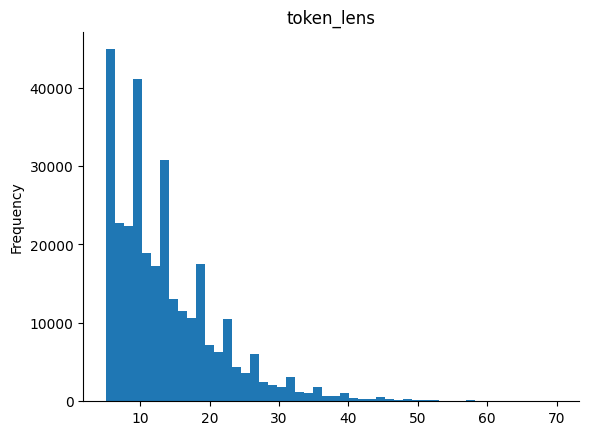

In [ ]:
df['token_lens'].plot(kind='hist', bins=50, title='token_lens')
plt.gca().spines[['top', 'right',]].set_visible(False)

Loading the initial dataset takes a long time, so I am saving the cleaned dataset here to speed up the process.

In [ ]:
# Save cleaned dataset to speed up future operations
#file_path = "dataset_clean.csv"
#df.to_csv(file_path, index=False)
#print("The cleaned DataFrame has been saved to:", file_path)

Il DataFrame è stato salvato correttamente in: dataset_clean.csv


### Sentiment tags

In this section, I utilized the VADER sentiment analysis tool to manually label a portion of the data. By selecting 1000 sentences from each philosophical school, I computed the sentiment score for each sentence and assigned sentiment labels ('positive', 'neutral', 'negative') based on the score. This process provided a straightforward and reliable way to create a labeled training dataset, which was then merged back with the original dataset. These labeled data will be used to train more complex models, such as BERT and in particular iSAX.


In [ ]:
df = pd.read_csv(r"/content/dataset_clean.csv")
df.head()

,school,sentence_str,text_clean,token_lens
0,plato,"What's new, Socrates, to make you leave your ...",new socrates make leave usual haunts lyceum sp...,13
1,plato,Surely you are not prosecuting anyone before t...,surely prosecuting anyone king archon,5
2,plato,The Athenians do not call this a prosecution b...,athenians call prosecution indictment euthyphro,5
3,plato,"Someone must have indicted you, for you are no...",someone must indicted going tell indicted some...,8
4,plato,"He belongs to the Pitthean deme, if you know a...",belongs pitthean deme know anyone deme called ...,15


In [ ]:
nltk.download('vader_lexicon')

# Function to calculate sentiment using VADER
def get_vader_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

# Sample 1800 sentences per school
sample_df = df.groupby('school').sample(1800, random_state = seed)

# Function to label sentiment
def label_sentiment(score):
    if score > 0.25:
        return 'positive'
    elif score >= -0.25:
        return 'neutral'
    else:
        return 'negative'

# Calculate VADER sentiment for sampled data
sample_df.loc[:, 'sentiment_vader'] = sample_df['text_clean'].apply(get_vader_sentiment);

# Apply the sentiment labeling function
sample_df.loc[:, 'Sentiment'] = sample_df['sentiment_vader'].apply(label_sentiment);

# Drop numerical sentiment scores
sample_df.drop(columns=['sentiment_vader'], inplace=True);

# Merge labeled data back to the original dataframe
df = pd.merge(df, sample_df[['sentence_str', 'Sentiment']], on='sentence_str', how='left');

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Count sentiment labels per school
sentiment_counts = df.groupby(['school', 'Sentiment']).size().unstack(fill_value=0)
print(sentiment_counts)

Sentiment        negative  neutral  positive
school                                      
analytic              223      959       618
aristotle             274      809       717
capitalism            193      629       978
communism             272      818       710
continental           449      823       528
empiricism            241      671       888
feminism              441      591       768
german_idealism       218      821       761
nietzsche             425      644       731
phenomenology         226      964       610
plato                 297      643       860
rationalism           287      575       938
stoicism              374      629       797


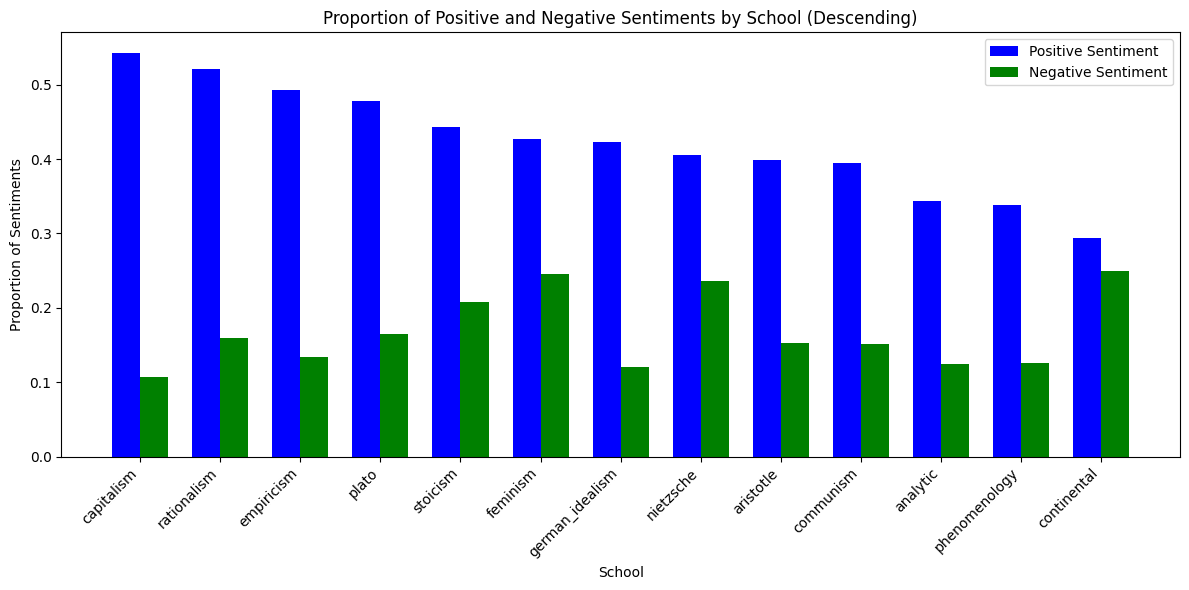

In [ ]:
# Calculate the proportion of positive and negative sentiments for each school
proportion_positive = sample_df.groupby('school')['Sentiment'].apply(lambda x: (x == 'positive').mean())
proportion_negative = sample_df.groupby('school')['Sentiment'].apply(lambda x: (x == 'negative').mean())

# Sort the proportions in descending order
proportion_positive_sorted = proportion_positive.sort_values(ascending=False)
proportion_negative_sorted = proportion_negative.reindex(proportion_positive_sorted.index)

# Plot proportions of positive and negative sentiments
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(proportion_positive_sorted))

plt.bar(index, proportion_positive_sorted, bar_width, label='Positive Sentiment', color='blue')
plt.bar(index + bar_width, proportion_negative_sorted, bar_width, label='Negative Sentiment', color='green')

plt.title('Proportion of Positive and Negative Sentiments by School (Descending)')
plt.xlabel('School')
plt.ylabel('Proportion of Sentiments')
plt.xticks(index + bar_width / 2, proportion_positive_sorted.index, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

From this histogram, we can observe that all philosophical schools tend to exhibit a more positive sentiment compared to negative. However, the difference between these sentiments varies significantly among different schools. For example, the capitalism school shows a notable disparity, whereas the difference is more subtle in the continental school. These results, obtained from a portion of the dataset using a rule-based model like VADER, are promising.

The reason for this is that the dataset does not include particularly negative works, nor does it feature authors known for gloomy perspectives, such as Schopenhauer. Instead, the dataset highlights more optimistic currents of thought. For instance, *capitalism* is associated with economic development, *communism* with worker rights and a more egalitarian society, and *Nietzsche* with the concept of the Übermensch. On the other hand, *continental* philosophers tend to have a more nuanced view, which might explain the more balanced sentiment distribution.

### Sentiment Analysis with BERT

Before starting model training, I want to discuss the following issue: In many NLP tasks, it is recommended to perform stemming or lemmatization on the texts before training the model. However, BERT uses BPE (Byte-Pair Encoding) to shrink its vocabulary size, so words like "run" and "running" will ultimately be decoded to "run" + "##ing." Therefore, it's better not to convert "running" into "run" because, in some NLP problems, you need that information. Additionally, in the cleaning phase, I noticed that I removed stopwords (including articles, which are very frequent in texts), but this wasn't necessary because BERT uses the Transformer model, which works on the attention principle. So when you fine-tune it on any problem, it will focus only on those words that impact the output and not on words common to all data. This procedure has been tested through a series of attempts to achieve the highest possible accuracy and F1 scores, and I have also tried to maintain a similar preprocessing phase to later compare it with iSAX. It has been a trade-off between performance and enabling a comparison between the models.

In [ ]:
df.sample(5, random_state = seed)

,school,sentence_str,text_clean,token_lens,Sentiment
129882,analytic,"It can be you who kills the victim, even thoug...",kills victim even though another killer standi...,17,NaN
187197,phenomenology,These considerations enable us to restore to t...,considerations enable us restore act speaking ...,8,positive
29142,aristotle,For since it has been proved that if B's being...,since proved b 's follows 's b 's possibility ...,22,NaN
215282,german_idealism,The concept of twelve is by no means already t...,concept twelve means already thought merely th...,19,NaN
68452,aristotle,It is also attended by a certain pleasure beca...,also attended certain pleasure thoughts dwell ...,16,positive


As first I separate the labeled data from the unlabeled data

In [ ]:
# Checks whether there are null values in the sentiment_tag column.
null_values = df['Sentiment'].isnull().sum()
print(f"Total number of null values in the Sentiment column: {null_values}\nTotal number of not null values in the Sentiment column: {len(df)-null_values}")

Total number of null values in the Sentiment column: 284533
Total number of not null values in the Sentiment column: 23400


In [ ]:
# untagged data in the Sentiment column
no_tag_df = df[df['Sentiment'].isnull()]

# tagged data in the Sentiment column
tag_df = df.dropna(subset=['Sentiment'])

# check dimensions
print("tagged data dimension:", tag_df.shape)
print("untagged data dimension:", no_tag_df.shape)

tagged data dimension: (23400, 5)
untagged data dimension: (284533, 5)


In [ ]:
#First, we import the BERT tokenizer.
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In this step, I calculate the token lengths of each cleaned sentence using the BERT tokenizer. This helps me determine the appropriate maximum token length for input sequences to the BERT model, ensuring I handle sentences of varying lengths correctly. Despite performing a similar length calculation during the initial preprocessing, the BERT tokenizer processes text differently (e.g., subword tokenization and adding special tokens), resulting in different token lengths. Therefore, this step is crucial to accurately gauge the input size requirements for my BERT model.

In [ ]:
token_lens = []

for txt in tag_df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

tag_df['token_lens'] = token_lens
tag_df.head()

MAX TOKENIZED SENTENCE LENGTH: 112


<ipython-input-59-5e7a409a185e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tag_df['token_lens'] = token_lens


,school,sentence_str,text_clean,token_lens,Sentiment
7,plato,"He is likely to be wise, and when he sees my i...",likely wise sees ignorance corrupting contempo...,13,neutral
9,plato,"So, too, Meletus first gets rid of us who corr...",meletus first gets rid us corrupt young shoots...,30,positive
16,plato,"One need not worry about them, but meet them h...",one need worry meet head,7,negative
30,plato,"The victim was a dependent of mine, and when w...",victim dependent mine farming naxos servant,10,negative
32,plato,During that time he gave no thought or care to...,time gave thought care bound man killer matter...,11,negative


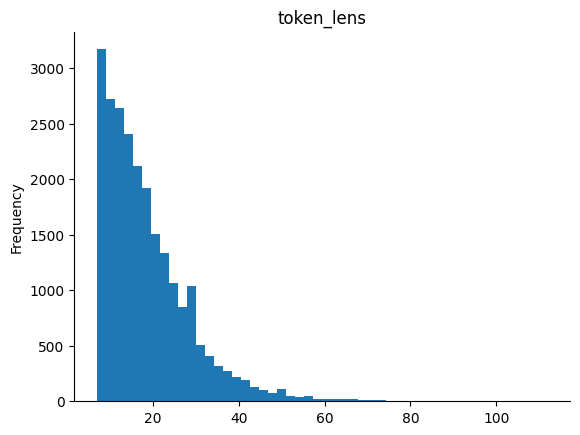

In [ ]:
tag_df['token_lens'].plot(kind='hist', bins=50, title='token_lens')
plt.gca().spines[['top', 'right',]].set_visible(False)

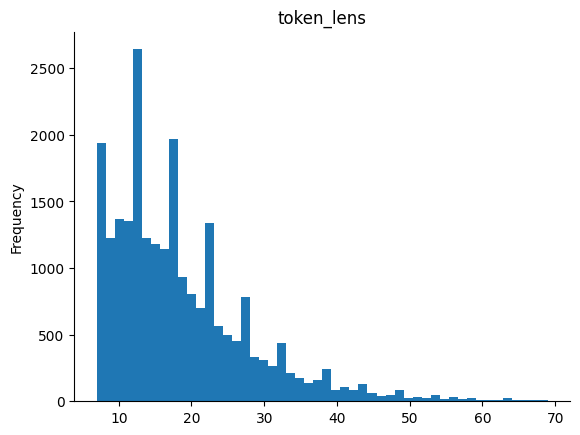

In [ ]:
tag_df = tag_df[tag_df['token_lens'] < 70]
tag_df['token_lens'].plot(kind='hist', bins=50, title='token_lens')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
tag_df.head()

,school,sentence_str,text_clean,token_lens,Sentiment
7,plato,"He is likely to be wise, and when he sees my i...",likely wise sees ignorance corrupting contempo...,13,neutral
9,plato,"So, too, Meletus first gets rid of us who corr...",meletus first gets rid us corrupt young shoots...,30,positive
16,plato,"One need not worry about them, but meet them h...",one need worry meet head,7,negative
30,plato,"The victim was a dependent of mine, and when w...",victim dependent mine farming naxos servant,10,negative
32,plato,During that time he gave no thought or care to...,time gave thought care bound man killer matter...,11,negative


In [ ]:
# I will shuffle the df and reset the index
tag_df = tag_df.sample(frac=1).reset_index(drop=True)
tag_df.head()

,school,sentence_str,text_clean,token_lens,Sentiment
0,stoicism,If this be so; that the most perfect and gener...,perfect general nature natures operation come ...,16,positive
1,continental,Levinas says it well: Violence can only aim at...,levinas says well violence aim face la violence,11,negative
2,aristotle,which we have named last must be a third kind.,named last must third kind,7,positive
3,capitalism,"They would be obliged, in consequence, to keep...",would obliged consequence keep times coffers g...,28,positive
4,stoicism,"Finally, love mankind; obey God.",finally love mankind obey god,7,positive


Do the same for the untagged data

MAX TOKENIZED SENTENCE LENGTH: 131


<ipython-input-64-23b442de5355>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_tag_df['token_lens'] = token_lens


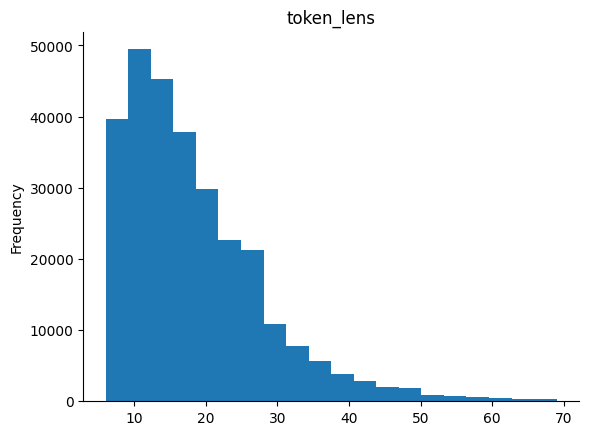

In [ ]:
token_lens = []

for txt in no_tag_df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

no_tag_df['token_lens'] = token_lens

no_tag_df.head()

no_tag_df = no_tag_df[no_tag_df['token_lens'] < 70]
no_tag_df['token_lens'].plot(kind='hist', bins=20, title='token_lens')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
# no_tag_df.to_csv('no_tag_df.csv', index=False)
# tag_df.to_csv('tag_df.csv', index=False)

#### Sentiment Column Analysis

Before training the model, I mapped the negative, neutral and positive sentiment into numerical values to simplify the analysis.

 It is important to note that the data are unbalanced.

 To handle the unbalanced data problem, I used the RandomOverSampler technique, which generated new data from the minority class. Finally, I extracted the input data and its labels for the training phase and organized them in a new DataFrame.

In [ ]:
tag_df['Sentiment'].value_counts()

Sentiment
positive    9876
neutral     9570
negative    3908
Name: count, dtype: int64

In [ ]:
tag_df['Sentiment'] = tag_df['Sentiment'].map({'negative':0,'neutral':1,'positive':2})
tag_df['Sentiment'].value_counts()

Sentiment
2    9876
1    9570
0    3908
Name: count, dtype: int64

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(tag_df['text_clean']).reshape(-1, 1), np.array(tag_df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [ ]:
train_os['Sentiment'].value_counts()

Sentiment
2    9876
0    9876
1    9876
Name: count, dtype: int64

In [ ]:
train_os.isnull().sum()

text_clean    0
Sentiment     0
dtype: int64

TRAIN / VALIDATION / TEST SPLIT

- **Splitting the Data:** The dataset is divided into training, validation, and testing sets using the `train_test_split` function. The `test_size` parameter is set to 0.1, ensuring that 10% of the data is reserved for testing. The `stratify` parameter is used to preserve the class distribution in the splits.

- **Further Splitting:** The combined training-validation set is split into separate training and validation sets using `train_test_split` again. This time, the validation set is set to 10% of the combined set.

- **One-Hot Encoding:** The labels are one-hot encoded using `OneHotEncoder` from scikit-learn to convert categorical integer labels into binary vectors. After performing some tests, by using one hot encoding on the target variable I achieved higher accuracy. For this reason I will choose one hot enconding over label encoding.

In [ ]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.1, stratify=y_train_val, random_state=seed)

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 23998
VALIDATION DATA: 2667
TESTING DATA: 2963


#### BERT

In [ ]:
MAX_LEN=150

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

# Then, I apply the tokenizer function to the train, validation and test sets.
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

Now I can import the BERT model from the pretrained library from Hugging face.

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased');

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Then, I create a custom function to host the pre trained BERT model, and attach to it a 3 neurons output layer, necessary to perform the classification of the 3 different classes of the dataset (the 3 emotions).

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):
    # Define optimizer with learning rate only
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

    # Define loss function and accuracy metric
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Define input layers
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # Get BERT embeddings
    embeddings = bert_model([input_ids, attention_masks])[1]

    # Add Dropout layer
    dropout = tf.keras.layers.Dropout(0.4)(embeddings)

    # Define output layer
    output = tf.keras.layers.Dense(3, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.01))(dropout)

    # Define and compile the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)
    model.compile(optimizer=opt, loss=loss, metrics=accuracy)

    return model

# Create and summarize the model
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 150, 7                                           
                             68),                                                             

In [ ]:
tf.config.list_physical_devices('GPU') #--> faster train (colab GPU)

history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=3, batch_size=8)

Epoch 1/3
3000/3000 [==============================] - 938s 286ms/step - loss: 0.6242 - categorical_accuracy: 0.7572 - val_loss: 0.3868 - val_categorical_accuracy: 0.8800
Epoch 2/3
3000/3000 [==============================] - 843s 281ms/step - loss: 0.3005 - categorical_accuracy: 0.9070 - val_loss: 0.2668 - val_categorical_accuracy: 0.9156
Epoch 3/3
3000/3000 [==============================] - 835s 278ms/step - loss: 0.1914 - categorical_accuracy: 0.9479 - val_loss: 0.3077 - val_categorical_accuracy: 0.9179


#### Analyze the Results


In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

93/93 [==============================] - 41s 329ms/step


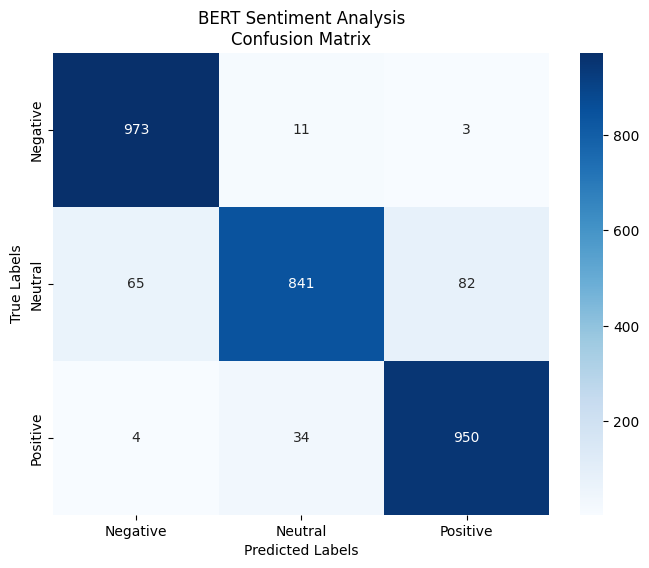

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_test.argmax(1), y_pred_bert.argmax(1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('BERT Sentiment Analysis\nConfusion Matrix')
plt.show()

Effettuo analisi del sentimento sui dati non taggati e visulaizzo i risultati

In [ ]:
print("Test Accuracy:", accuracy_score(y_test, y_pred_bert))

Test Accuracy: 0.932838339520756


In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.93      0.99      0.96       987
     Neutral       0.95      0.85      0.90       988
    Positive       0.92      0.96      0.94       988

   micro avg       0.93      0.93      0.93      2963
   macro avg       0.93      0.93      0.93      2963
weighted avg       0.93      0.93      0.93      2963
 samples avg       0.93      0.93      0.93      2963



### Sentiment Analysis with roBERTa

As seen for BERT, I will first import the tokenizer used to train the original roberta transformer

In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

First, I check the length of the longest tokenized sentence by roberta tokenizer:

In [ ]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_len = np.max(token_lens)

print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 71


Then I define the tokenization function

In [ ]:
MAX_LEN = 150

def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

#### roBERTa

In [ ]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

roberta_model = TFRobertaModel.from_pretrained('roberta-base')

model1 = create_model(roberta_model, MAX_LEN)
model1.summary()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_3[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_4[0][0]']             
                             hidden_state=(None, 150, 7                                           
                             68),                                                           

In [ ]:
tf.config.list_physical_devices('GPU') #--> faster train (colab GPU)
history_1 = model1.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=3, batch_size=8)

Epoch 1/3
3000/3000 [==============================] - 930s 290ms/step - loss: 0.5895 - categorical_accuracy: 0.7566 - val_loss: 0.3724 - val_categorical_accuracy: 0.8553
Epoch 2/3
3000/3000 [==============================] - 854s 285ms/step - loss: 0.3194 - categorical_accuracy: 0.8787 - val_loss: 0.2847 - val_categorical_accuracy: 0.8946
Epoch 3/3
3000/3000 [==============================] - 839s 280ms/step - loss: 0.2200 - categorical_accuracy: 0.9188 - val_loss: 0.3513 - val_categorical_accuracy: 0.8909


#### Analyze the Results

In [ ]:
# make the predictions
result_roberta = model1.predict([test_input_ids,test_attention_masks])

y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

93/93 [==============================] - 40s 316ms/step


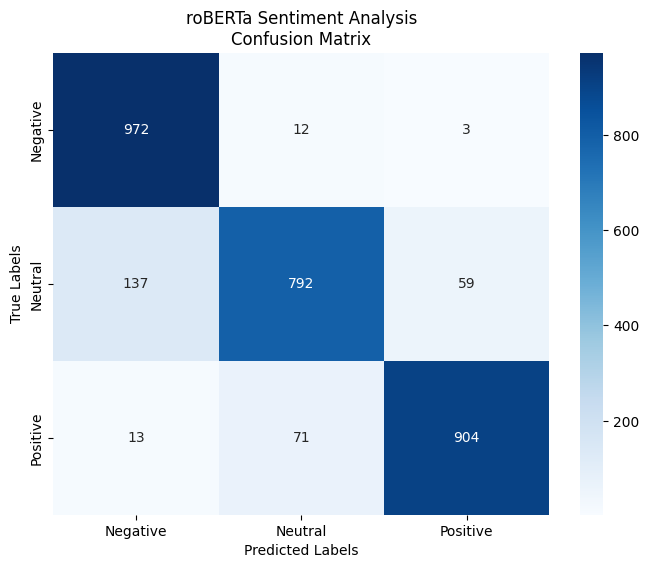

In [ ]:
# Calculate the confusion matrix
cm1 = confusion_matrix(y_test.argmax(1), y_pred_roberta.argmax(1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('roBERTa Sentiment Analysis\nConfusion Matrix')
plt.show()

In [ ]:
print("Test Accuracy:", accuracy_score(y_test, y_pred_roberta))

Test Accuracy: 0.9004387445156935


In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.87      0.98      0.92       987
     Neutral       0.91      0.80      0.85       988
    Positive       0.94      0.91      0.93       988

   micro avg       0.90      0.90      0.90      2963
   macro avg       0.90      0.90      0.90      2963
weighted avg       0.90      0.90      0.90      2963
 samples avg       0.90      0.90      0.90      2963



### Performance Comparison between BERT and RoBERTa

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.93      0.99      0.96       987
     Neutral       0.95      0.85      0.90       988
    Positive       0.92      0.96      0.94       988

   micro avg       0.93      0.93      0.93      2963
   macro avg       0.93      0.93      0.93      2963
weighted avg       0.93      0.93      0.93      2963
 samples avg       0.93      0.93      0.93      2963



In [ ]:
print("Test Accuracy:", accuracy_score(y_test, y_pred_bert))

Test Accuracy: 0.932838339520756


In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.87      0.98      0.92       987
     Neutral       0.91      0.80      0.85       988
    Positive       0.94      0.91      0.93       988

   micro avg       0.90      0.90      0.90      2963
   macro avg       0.90      0.90      0.90      2963
weighted avg       0.90      0.90      0.90      2963
 samples avg       0.90      0.90      0.90      2963



In [ ]:
print("Test Accuracy:", accuracy_score(y_test, y_pred_roberta))

Test Accuracy: 0.9004387445156935


BERT demonstrates superior performance across all sentiment categories, achieving higher precision, recall, and F1-scores compared to RoBERTa.
The precision, recall, and F1-score for negative sentiment classification are notably higher with BERT, indicating its robustness in capturing negative sentiment nuances. BERT's overall test accuracy of 93.28% outperforms RoBERTa's accuracy of 90.04%, reaffirming its superiority in this sentiment analysis task.

### Predictions on Untagged Data

In [ ]:
# Tokenize the text in no_tag_df
test_input_ids, test_attention_masks = tokenize(no_tag_df['text_clean'].values, MAX_LEN)

# Make predictions using BERT
predictions = model.predict([test_input_ids, test_attention_masks])

# Decode predictions into sentiments
sentiments = np.argmax(predictions, axis=1)

# Add a "Sentiment" column to the dataframe with decoded sentiments
no_tag_df['Sentiment'] = ['negative' if sentiment == 0 else
                           'neutral' if sentiment == 1 else
                           'positive' for sentiment in sentiments]
no_tag_df.sample(5)

8875/8875 [==============================] - 2927s 330ms/step


,school,sentence_str,text_clean,token_lens,Sentiment
229195,german_idealism,The aim of the foregoing has been to highlight...,aim foregoing highlight simple specific nature...,15,neutral
15933,plato,What Thrasymachus is now saying that the life ...,thrasymachus saying life unjust person better ...,18,positive
187627,phenomenology,Now blue and red are not those incommunicable ...,blue red incommunicable experiences mine coinc...,19,neutral
199687,phenomenology,itive cognition is as a kind of behav ior of t...,itive cognition kind behav ior soul consciousness,13,positive
32536,aristotle,"Both, then, will not be genera, and consequent...",genera consequently state genus virtue clearly...,10,positive


In [ ]:
# no_tag_df.to_csv('no_tag_df_with_sentiments.csv', index=False)
# tag_df.to_csv('tag_df_with_sentiments.csv', index=False)

In [ ]:
sentiment_mapping = {0: 'negative', 1: 'neutral', 2: 'positive'}
tag_df['Sentiment'] = tag_df['Sentiment'].map(sentiment_mapping)
combined_df = pd.concat([no_tag_df, tag_df], ignore_index=True)

<ipython-input-102-685794efd8d5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Sentiment'] = filtered_df['Sentiment'].map({'positive': 1, 'negative': -1})
<ipython-input-102-685794efd8d5>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='school', y='Sentiment', data=sentiment_mean, palette='viridis')


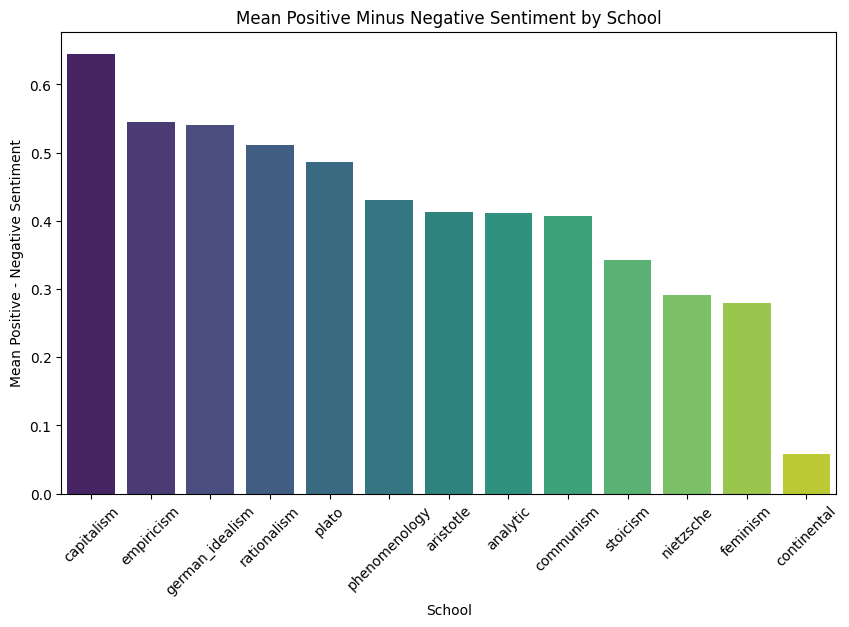

In [ ]:
# Filter only positive and negative sentiments
filtered_df = combined_df[combined_df['Sentiment'].isin(['positive', 'negative'])]

# Encode the sentiments: 1 for positive, -1 for negative
filtered_df['Sentiment'] = filtered_df['Sentiment'].map({'positive': 1, 'negative': -1})

# Calculate the mean sentiment for each school
sentiment_mean = filtered_df.groupby('school')['Sentiment'].mean().reset_index()
# Sort the DataFrame in descending order based on the mean sentiment
sentiment_mean = sentiment_mean.sort_values(by='Sentiment', ascending=False)

# create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='school', y='Sentiment', data=sentiment_mean, palette='viridis')
plt.xlabel('School')
plt.ylabel('Mean Positive - Negative Sentiment')
plt.title('Mean Positive Minus Negative Sentiment by School')
plt.xticks(rotation=45)
plt.show()

Capitalism, Empiricism, and German Idealism: These philosophical schools exhibit higher mean positive minus negative sentiment values, indicating that discussions or texts associated with these schools tend to express more positive sentiments than negative ones. This could be attributed to the optimistic viewpoints or theories often associated with these philosophical traditions, which may resonate positively with readers or audiences.

Nietzsche, Feminism, and Continental Philosophy: While these schools have lower mean positive minus negative sentiment values compared to the former group, they still maintain positive sentiment averages above zero. This suggests that discussions or texts related to these schools tend to have a balanced or slightly positive sentiment overall. Possible explanations could include the nuanced and thought-provoking nature of Nietzsche's writings, the empowering themes often found in feminist discourse, and the diverse and complex perspectives within continental philosophy.

Overall Observation: The variation in sentiment values across different philosophical schools highlights the diversity of thought and expression within the philosophical landscape. While some schools may lean towards more positive sentiments, others may exhibit a more balanced or nuanced sentiment profile. This underscores the richness and complexity of philosophical discourse, where differing perspectives and interpretations contribute to the dynamic exchange of ideas.

***MORE DETAILS***

**Analysis of Philosophical Schools: Understanding Sentiment through Textual Perspectives**

- Capitalism

 The high ranking of capitalism may stem from its portrayal as a system that fosters economic growth, individual agency, and innovation, themes often positively depicted in the texts analyzed.

- Empiricism

 Empiricism's emphasis on verifiable evidence and scientific inquiry likely resonates positively with texts advocating for a rational and empirical approach to understanding the world. Its promotion of evidence-based reasoning aligns with the values reflected in the texts, contributing to a favorable sentiment towards empiricism within the corpus.

- German Idealism

 German Idealism's exploration of reason, freedom, and the unity of mind and world may find resonance in texts emphasizing human reason and rationality. Themes such as human agency and the pursuit of knowledge may contribute to a positive sentiment towards German Idealism in the corpus.

- Rationalism

 Rationalism's stress on reason and innate ideas may be admired in texts valuing intellectual rigor and logical coherence. However, its reliance on deductive reasoning and a priori knowledge may be viewed skeptically in texts that prioritize empirical evidence and experiential knowledge, leading to a more mixed sentiment towards rationalism.

- Phenomenology

 Phenomenology's examination of lived experience and subjective consciousness may appeal to texts interested in exploring the depths of human experience. While this approach may resonate positively with some texts, others may find its descriptive and abstract methods less accessible or relevant, contributing to a mixed sentiment towards phenomenology.

- Aristotelianism

 Aristotelianism's holistic approach to ethics, politics, and natural philosophy may be valued in texts seeking practical guidance on leading virtuous lives. However, its hierarchical view of the natural world may be challenged in texts advocating for more egalitarian or non-hierarchical perspectives, resulting in a mixed sentiment towards Aristotelianism.

- Analytic Philosophy

 Analytic philosophy's dedication to clarity, precision, and logical analysis may be appreciated in texts seeking rigorous and systematic approaches to philosophical inquiry. However, its emphasis on technical language and formal methods may be critiqued in texts seeking more socially relevant or engaged philosophies, resulting in a mixed sentiment towards analytic philosophy.

- Communism

 The sentiment towards communism may vary depending on the portrayal of its critique of capitalism and advocacy for social equality in the corpus. Texts sympathetic to its aims of social justice and collective ownership may depict communism positively, while others may critique its association with authoritarian regimes and historical failures, resulting in a mixed sentiment.

- Stoicism

 Stoicism's focus on resilience and acceptance of fate may find resonance in texts seeking practical wisdom for navigating life's challenges. However, its emphasis on emotional detachment and suppression of desires may be critiqued in texts valuing emotional authenticity and vulnerability, contributing to a mixed sentiment towards Stoicism.

- Nietzscheanism

 Nietzscheanism's critique of traditional values and celebration of individualism may resonate with texts advocating for empowerment and personal growth. However, its association with nihilism and elitism may be critiqued in texts valuing inclusivity and social cohesion, resulting in a mixed sentiment towards Nietzscheanism.

- Feminism

 Feminism's advocacy for gender equality and social justice may be appreciated in texts supportive of its aims of inclusivity and empowerment. However, its association with identity politics and internal debates over intersectionality and tactics may prompt critique in texts wary of ideological rigidity or concerned about unintended consequences, resulting in a mixed sentiment towards feminism.

- Continental Philosophy

 Continental philosophy's engagement with existential questions, phenomenological inquiries, and critical perspectives on society may be valued in texts addressing the complexities of human existence and societal dynamics. However, its dense and esoteric language, may limit its accessibility or appeal in some texts, resulting in a mixed sentiment towards continental philosophy.


## CLASSIFICATION

### Select the right column of the dataset

In [ ]:
df=DATASET
df = df[['school', 'text_clean']]
df.sample(5)

,school,text_clean
129882,analytic,kills victim even though another killer standi...
187197,phenomenology,considerations enable us restore act speaking ...
29142,aristotle,since proved b 's follows 's b 's possibility ...
215282,german_idealism,concept twelve means already thought merely th...
68452,aristotle,also attended certain pleasure thoughts dwell ...


### Keep only 20% of the dataset for the first training models

In [ ]:

'''#I keep only 20% of the dataset
# Randomly sample 10% of the dataset
data = df.sample(frac=0.2, random_state=42)
df = data

This was used to train the model on a smaller dataset in order to find the best values of the hyper-parameters to be used, so as to decrease the learning time. When we then found the right values, we no longer needed this cell and trained the model on the entire dataset.

### Cleaning Dataset

In [ ]:
# Filter out sentences that are too short or too long
print(f"Size before removal of insignificant sentences: {len(df)}")
df = df[(df['token_lens'] >= 5) & (df['token_lens'] <= 70)]
print(f"Size after removal of insignificant sentences: {len(df)}")

Size before removal of insignificant sentences: 360808
Size after removal of insignificant sentences: 307933


### See the composition of the classes

In [ ]:
# Calcola la frequenza di ciascuna classe nella colonna 'target_column'
class_counts = df['school'].value_counts()

# Calcola la percentuale di ciascuna classe
class_percentages = class_counts / len(df) * 100

# Stampa i risultati
for class_name, percentage in class_percentages.items():
    print(f'{class_name}: {percentage:.2f}%')

analytic: 14.64%
aristotle: 14.01%
german_idealism: 12.16%
continental: 9.80%
plato: 9.12%
phenomenology: 7.94%
rationalism: 6.57%
empiricism: 5.72%
capitalism: 5.55%
feminism: 5.29%
communism: 5.13%
nietzsche: 3.40%
stoicism: 0.67%


Here we can see that the dataset is unbalanced. This as we shall see may be a problem, but the final model still manages to recognise even the least represented classes within the dataset.

### Division into train, validation and test set

In [ ]:
X = df['text_clean'].values
y = df['school'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=seed)

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 147807
VALIDATION DATA: 36952
TESTING DATA: 123174


### Tokenize the sets as BERT's model requires, load the model and define metrics.

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data
train_encodings = tokenizer(list(X_train), max_length=70,padding=True, truncation=True, return_tensors='pt')
valid_encodings = tokenizer(list(X_valid), max_length=70, padding=True, truncation=True, return_tensors='pt')
test_encodings = tokenizer(list(X_test), max_length=70, padding=True, truncation=True, return_tensors='pt')

# Encode the labels
label_encoder = LabelEncoder()
train_labels = torch.tensor(label_encoder.fit_transform(y_train), dtype=torch.long)
valid_labels = torch.tensor(label_encoder.transform(y_valid), dtype=torch.long)
test_labels = torch.tensor(label_encoder.transform(y_test), dtype=torch.long)


# Define a custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)


# Prepare datasets
train_dataset = TextDataset(train_encodings, train_labels)
valid_dataset = TextDataset(valid_encodings, valid_labels)
test_dataset = TextDataset(test_encodings, test_labels)

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['school'].unique()), hidden_dropout_prob=0.38)
'''
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}
'''

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Definition of model parameters

In [ ]:

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=12,  # Start with a batch size of 12
    per_device_eval_batch_size=12,
    gradient_accumulation_steps=2,  # Effective batch size of 24
    warmup_steps=500,
    weight_decay=0.1,
    #logging_dir='./logs',
    #logging_steps=10,
    eval_strategy="no",
    eval_steps=0,
    save_steps=0,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)



# Train the model
trainer.train()

# Evaluate the model on the validation set
val_results = trainer.evaluate(eval_dataset=valid_dataset)
print(f'Validation Accuracy: {val_results["eval_accuracy"]}')
print(f'Validation Precision: {val_results["eval_precision"]}')
print(f'Validation Recall: {val_results["eval_recall"]}')
print(f'Validation F1 Score: {val_results["eval_f1"]}')

# Evaluate the model on the test set
test_results = trainer.evaluate(eval_dataset=test_dataset)
print(f'Test Accuracy: {test_results["eval_accuracy"]}')
print(f'Test Precision: {test_results["eval_precision"]}')
print(f'Test Recall: {test_results["eval_recall"]}')
print(f'Test F1 Score: {test_results["eval_f1"]}')

# Evaluate the model on the train set
train_results = trainer.evaluate(eval_dataset=train_dataset)
print(f'Train Accuracy: {train_results["eval_accuracy"]}')
print(f'Train Precision: {train_results["eval_precision"]}')
print(f'Train Recall: {train_results["eval_recall"]}')
print(f'Train F1 Score: {train_results["eval_f1"]}')

Step,Training Loss
500,2.212000
1000,1.596600
1500,1.380400
2000,1.260900
2500,1.183100
3000,1.127800
3500,1.098700
4000,1.045200
4500,1.025900
5000,0.995300


Validation Accuracy: 0.7873998701017536
Validation Precision: 0.7904678377354969
Validation Recall: 0.7873998701017536
Validation F1 Score: 0.7866730905411438
Test Accuracy: 0.7879503791384546
Test Precision: 0.791387409925641
Test Recall: 0.7879503791384546
Test F1 Score: 0.7874999991128918
Train Accuracy: 0.8589241375577611
Train Precision: 0.8612056880355905
Train Recall: 0.8589241375577611
Train F1 Score: 0.8585400226585705


### Results and confusion matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Make predictions on the test dataset
predictions = trainer.predict(test_dataset)

# Extract predicted labels and convert them back to original class labels
predicted_labels = np.argmax(predictions.predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_labels)

# Convert true labels back to original class labels
#true_labels = label_encoder.inverse_transform(y_test)

# Now you have y_pred and y_true
y_pred = predicted_labels
y_true = y_test#true_labels

# Assuming you have already trained your BERT model and obtained predictions
# Replace `y_pred` with your predicted labels and `y_true` with your true labels

# Calculate classification report
report = classification_report(y_true, y_pred)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report and confusion matrix
print("Classification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

Classification Report:
                 precision    recall  f1-score   support

       analytic       0.80      0.86      0.83     18032
      aristotle       0.78      0.85      0.81     17255
     capitalism       0.83      0.89      0.86      6833
      communism       0.85      0.78      0.81      6314
    continental       0.81      0.75      0.78     12073
     empiricism       0.80      0.71      0.76      7050
       feminism       0.76      0.79      0.77      6516
german_idealism       0.87      0.80      0.83     14973
      nietzsche       0.84      0.59      0.70      4188
  phenomenology       0.79      0.72      0.75      9785
          plato       0.71      0.77      0.74     11232
    rationalism       0.66      0.75      0.70      8097
       stoicism       0.71      0.56      0.63       826

       accuracy                           0.79    123174
      macro avg       0.79      0.76      0.77    123174
   weighted avg       0.79      0.79      0.79    123174


Conf

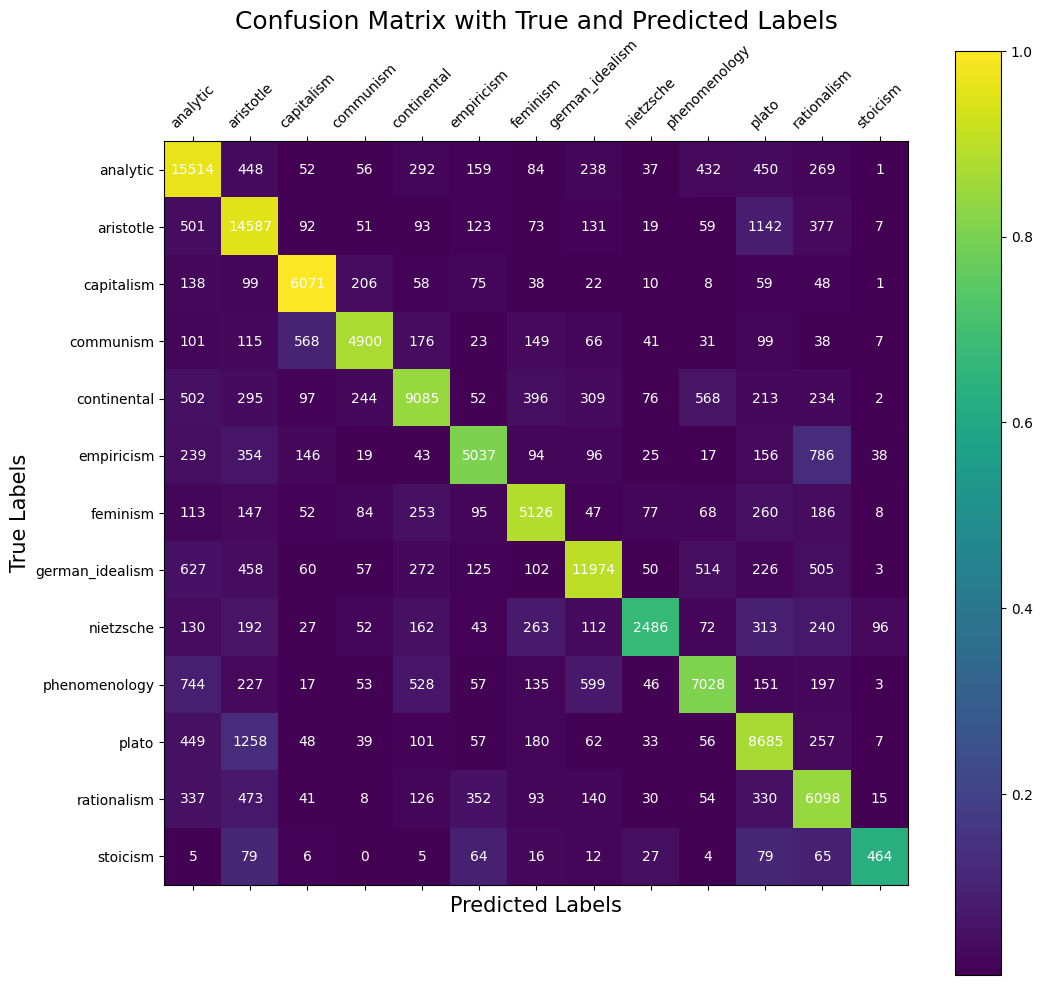

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

a = np.array([[15514, 448, 52, 56, 292, 159, 84, 238, 37, 432, 450, 269, 1],
              [501, 14587, 92, 51, 93, 123, 73, 131, 19, 59, 1142, 377, 7],
              [138, 99, 6071, 206, 58, 75, 38, 22, 10, 8, 59, 48, 1],
              [101, 115, 568, 4900, 176, 23, 149, 66, 41, 31, 99, 38, 7],
              [502, 295, 97, 244, 9085, 52, 396, 309, 76, 568, 213, 234, 2],
              [239, 354, 146, 19, 43, 5037, 94, 96, 25, 17, 156, 786, 38],
              [113, 147, 52, 84, 253, 95, 5126, 47, 77, 68, 260, 186, 8],
              [627, 458, 60, 57, 272, 125, 102, 11974, 50, 514, 226, 505, 3],
              [130, 192, 27, 52, 162, 43, 263, 112, 2486, 72, 313, 240, 96],
              [744, 227, 17, 53, 528, 57, 135, 599, 46, 7028, 151, 197, 3],
              [449, 1258, 48, 39, 101, 57, 180, 62, 33, 56, 8685, 257, 7],
              [337, 473, 41, 8, 126, 352, 93, 140, 30, 54, 330, 6098, 15],
              [5, 79, 6, 0, 5, 64, 16, 12, 27, 4, 79, 65, 464]])

# Nomi delle righe e delle colonne
school = ["analytic", "aristotle", "capitalism", "communism", "continental",
          "empiricism", "feminism", "german_idealism", "nietzsche", "phenomenology",
          "plato", "rationalism", "stoicism"]

row_totals = a.sum(axis=1, keepdims=True)

proportions = a / row_totals

# Definire una mappa di colori
cmap = plt.get_cmap('viridis')  # Puoi cambiare la mappa di colori

norm = mcolors.Normalize(vmin=0, vmax=proportions.max())

colored_matrix = cmap(norm(proportions))

fig, ax = plt.subplots(figsize=(12, 12))
cax = ax.matshow(colored_matrix, cmap=cmap)

# Aggiungere una barra di colore
fig.colorbar(cax)

# Aggiungere etichette alle celle
for (i, j), val in np.ndenumerate(a):
    ax.text(j, i, f'{val}', ha='center', va='center', color='white')

ax.set_xticks(np.arange(len(school)))
ax.set_yticks(np.arange(len(school)))
ax.set_xticklabels(school, rotation=45)
ax.set_yticklabels(school)

# Aggiungere i titoli per le etichette delle righe e delle colonne
ax.set_xlabel('Predicted Labels', fontsize=15)
ax.set_ylabel('True Labels', fontsize=15)

plt.title('Confusion Matrix with True and Predicted Labels', fontsize=18)
plt.show()
